In [2]:
!pip install pdf2image poppler-utils


In [3]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

# **PDF TO JPEG**

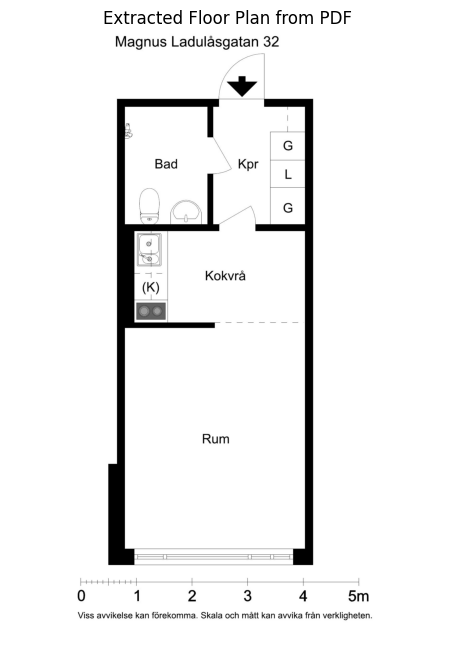

In [5]:
from pdf2image import convert_from_path

# Path to the uploaded PDF
pdf_path = "/content/1639436planritning-23kvm.pdf"

# Convert first page of PDF to an image
images = convert_from_path(pdf_path, first_page=1, last_page=1)

# Save the extracted image
image_path = "/content/pdf_to_jpeg_plan.jpeg"
images[0].save(image_path, "JPEG")

# Display the extracted floor plan image
extracted_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8, 8))
plt.imshow(extracted_image, cmap="gray")
plt.title("Extracted Floor Plan from PDF")
plt.axis("off")
plt.show()


# **APPLYING CANNY EDGE DETECTION**

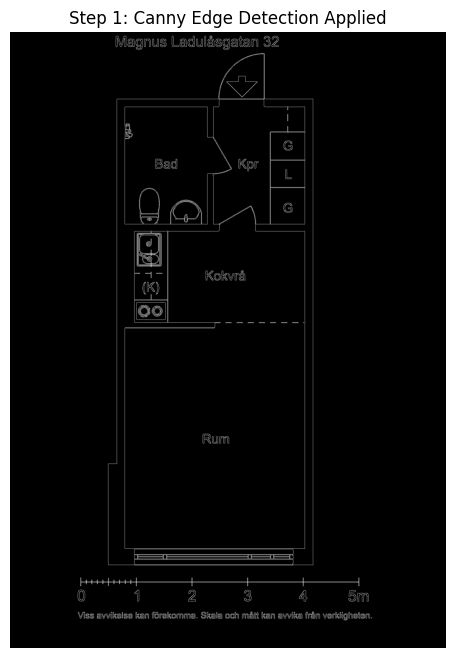

In [6]:
# Reload the correctly cropped floor plan image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# **Step 1: Apply Canny Edge Detection to Detect Floor Plan Boundaries**
edges = cv2.Canny(image, 50, 150)  # Apply edge detection

# Display the detected edges
plt.figure(figsize=(8, 8))
plt.imshow(edges, cmap="gray")
plt.title("Step 1: Canny Edge Detection Applied")
plt.axis("off")
plt.show()


# **FINIDING CONTOURS**

In [7]:
# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the bounding box around the largest detected contour (assumed to be the floor plan)
x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

# Output the bounding box coordinates
(x, y, w, h)


(372, 81, 779, 1944)

# **CROPPING THE IMAGE**

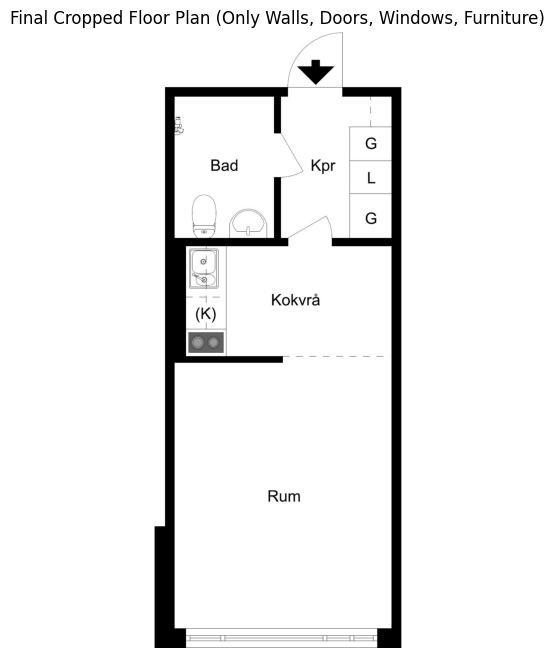

In [8]:
# Reload the image for better preprocessing
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# **Enhance contrast using Histogram Equalization**
equalized = cv2.equalizeHist(image)

# **Apply Adaptive Thresholding to separate walls from background**
thresh = cv2.adaptiveThreshold(equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 25, 5)

# **Morphological Operations to clean small details (text, symbols)**
kernel = np.ones((5, 5), np.uint8)  # Larger kernel for better filtering
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)

# **Find contours again, focusing only on the largest shape (the floor plan)**
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and assume the largest one is the floor plan
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Reduce the area threshold to capture the floor plan correctly
min_area_threshold = 30000  # Lowered to ensure the structure is detected
floor_plan_contour = None

for contour in contours:
    if cv2.contourArea(contour) > min_area_threshold:
        floor_plan_contour = contour
        break

# Ensure a valid contour was found
if floor_plan_contour is None:
    raise ValueError("Error: Could not detect the floor plan structure.")

# Get the bounding box around the detected floor plan contour
x, y, w, h = cv2.boundingRect(floor_plan_contour)

# **Crop the image using this refined bounding box**
cropped_floor_plan = image[y:y+h, x:x+w]

# Save the final correctly cropped floor plan
final_cropped_path = "/content/final_cropped_floor_plan.jpg"
cv2.imwrite(final_cropped_path, cropped_floor_plan)

# Display the final correctly cropped floor plan
plt.figure(figsize=(8, 8))
plt.imshow(cropped_floor_plan, cmap="gray")
plt.title("Final Cropped Floor Plan (Only Walls, Doors, Windows, Furniture)")
plt.axis("off")
plt.show()


# **CLEANING THE PLAN (removing text labels and furniture)**

In [20]:
!pip install pytesseract opencv-python numpy matplotlib
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,282 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

## **DETECTING SOLID WALLS**

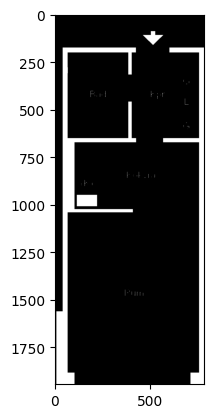

In [59]:
# Function to isolate walls and detect corner points
def detect_walls_and_corners(final_cropped_path):
    if final_cropped_path is None:
        print("⚠️ Error: Cropped image is None!")
        return []

    # Load the image using the provided path
    solid_extracted_walls = cv2.imread(final_cropped_path, cv2.IMREAD_GRAYSCALE)

    # Convert to binary image (ensure white walls, black background)
    _, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV) # Use the loaded image

    # Apply morphological operations to refine walls
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(binary, kernel, iterations=2)
    restored = cv2.dilate(eroded, kernel, iterations=2)  # Adjust if needed

    # Display the eroded and restored walls for debugging
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(eroded, cmap='gray')
    plt.axis("off")
    plt.title("Eroded Walls")

    plt.subplot(1, 2, 2)
    plt.imshow(restored, cmap='gray')
    plt.axis("off")
    plt.title("Restored Walls (After Dilation)")

    plt.show()

# Apply morphological operations to refine walls
image = cv2.imread(final_cropped_path, cv2.IMREAD_GRAYSCALE) # Load the image here as well
_, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV) # Use the loaded image
kernel = np.ones((5, 5), np.uint8)
eroded = cv2.erode(binary, kernel, iterations=1)

plt.imshow(eroded, cmap='gray')

In [60]:
# Function to isolate walls and detect corner points
def detect_walls_and_corners(final_cropped_path, output_image_path):
    if final_cropped_path is None:
        print("⚠️ Error: Cropped image is None!")
        return None

    # Load the image using the provided path
    solid_extracted_walls = cv2.imread(final_cropped_path, cv2.IMREAD_GRAYSCALE)

    # Convert to binary image (ensure white walls, black background)
    _, binary = cv2.threshold(solid_extracted_walls, 200, 255, cv2.THRESH_BINARY_INV)

    # Apply morphological operations to refine walls
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(binary, kernel, iterations=2)
    restored = cv2.dilate(eroded, kernel, iterations=2)  # Adjust if needed

    # Save the final extracted solid walls
    cv2.imwrite(output_image_path, restored)
    print(f"✅ Solid walls saved at: {output_image_path}")

    return output_image_path  # Return path for further processing

# Define input and output paths
final_cropped_path = "/content/final_cropped_floor_plan.jpg"  # Replace with actual cropped image path
output_walls_path = "/content/solid_extracted_walls.jpg"  # Name of saved file

# Run function
saved_walls_path = detect_walls_and_corners(final_cropped_path, output_walls_path)

# Now you can use `saved_walls_path` in the next step for defining corner coordinates!


✅ Solid walls saved at: /content/solid_extracted_walls.jpg


# **FULL CLEANING**

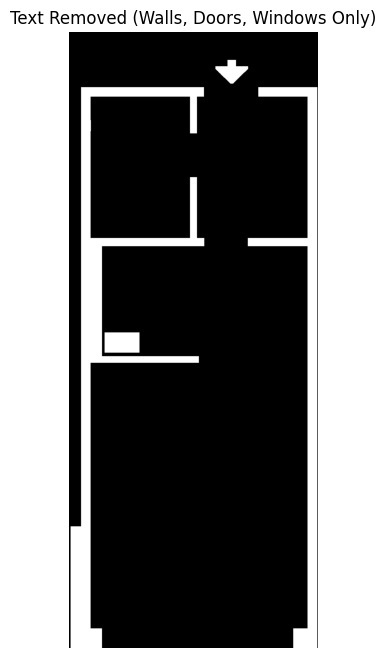

True

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

# Load the detected walls image
image = cv2.imread(output_walls_path , cv2.IMREAD_GRAYSCALE)

# Step 1: Adaptive Thresholding for better contrast
binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 25, 5)

# Step 2: Use Pytesseract to Detect Text
custom_config = r'--oem 3 --psm 6'  # Optimized for text detection
text_data = pytesseract.image_to_data(binary, config=custom_config, output_type=pytesseract.Output.DICT)

# Step 3: Create a Mask for Text Areas
mask = np.zeros_like(image)  # Black mask same size as image

for i in range(len(text_data["text"])):
    conf = int(text_data["conf"][i])
    if conf > 40 and len(text_data["text"][i].strip()) > 1:  # Ignore bad detections
        x, y, w, h = (text_data["left"][i], text_data["top"][i],
                      text_data["width"][i], text_data["height"][i])
        cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)  # White boxes where text is

# Step 4: Inpaint to Fill Text Areas with Nearby Pixels
cleaned_image = cv2.inpaint(image, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

# Step 5: Display the cleaned image
plt.figure(figsize=(8, 8))
plt.imshow(cleaned_image, cmap="gray")
plt.title("Text Removed (Walls, Doors, Windows Only)")
plt.axis("off")
plt.show()

# Save the final cleaned plan
cv2.imwrite("/content/final_cleaned_plan.jpg", cleaned_image)


`np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)


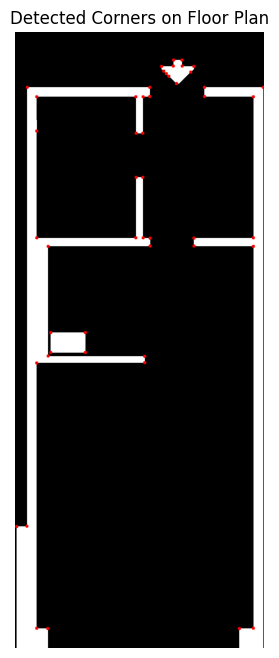

[(408, 1023),
 (499, 88),
 (103, 1882),
 (5, 1560),
 (104, 1022),
 (112, 1011),
 (112, 948),
 (104, 676),
 (402, 319),
 (381, 319)]

In [65]:
# Re-import required libraries since execution state was reset
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Reload the cleaned floor plan (only walls, doors, windows)
cleaned_plan_path = "/content/final_cleaned_plan.jpg"  # Update with correct path if needed
image = cv2.imread(cleaned_plan_path, cv2.IMREAD_GRAYSCALE)

# Ensure the image is loaded properly
if image is None:
    raise ValueError("Error loading the cleaned floor plan image.")

# Detect corners using Shi-Tomasi Corner Detection
corners = cv2.goodFeaturesToTrack(image, maxCorners=50, qualityLevel=0.02, minDistance=10)
corners = np.int0(corners)  # Convert to integer coordinates

# Convert image to color for visualization
corner_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw detected corners
for i in corners:
    x, y = i.ravel()
    cv2.circle(corner_image, (x, y), 5, (0, 0, 255), -1)  # Red dots for corners

# Display the detected corners
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Corners on Floor Plan")
plt.axis("off")
plt.show()

# Store the corner coordinates
corner_coordinates = [(i.ravel()[0], i.ravel()[1]) for i in corners]

# Display first 10 detected corners for verification
corner_coordinates[:10]


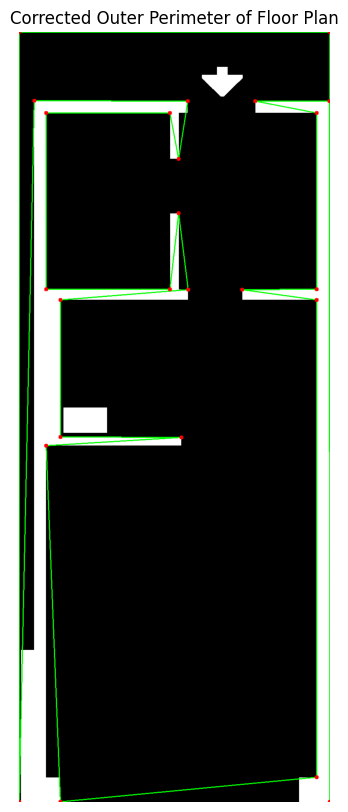

[(0, 0),
 (0, 1943),
 (38, 173),
 (425, 174),
 (402, 320),
 (380, 204),
 (68, 204),
 (68, 649),
 (380, 649),
 (402, 457),
 (426, 650),
 (104, 676),
 (104, 1022),
 (409, 1023),
 (68, 1044),
 (104, 1943),
 (750, 1881),
 (750, 676),
 (562, 650),
 (750, 649),
 (750, 204),
 (595, 174),
 (782, 174),
 (783, 1943),
 (783, 0)]

In [70]:
# Re-import necessary libraries after execution state reset
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Reload the cleaned floor plan image
image_path = "/content/final_cleaned_plan.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply thresholding to create a binary image
_, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the largest contour (assumed to be the outer perimeter)
largest_contour = max(contours, key=cv2.contourArea)

# Approximate the contour to get cleaner edges
epsilon = 0.005 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

# Draw the updated perimeter on the image
perimeter_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(perimeter_image, [approx], -1, (0, 255, 0), 2)

# Highlight detected corners
for point in approx:
    x, y = point.ravel()
    cv2.circle(perimeter_image, (x, y), 5, (255, 0, 0), -1)

# Display the corrected outer perimeter
plt.figure(figsize=(6, 10))
plt.imshow(perimeter_image, cmap="gray")
plt.title("Corrected Outer Perimeter of Floor Plan")
plt.axis("off")
plt.show()

# Extract the final perimeter coordinates
final_perimeter_coordinates = [tuple(pt[0]) for pt in approx]
final_perimeter_coordinates


# **(WORK IN PROGRESS, TO BE CONTINUED!)**